In [1]:
import jax.numpy as jnp
import jax
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_default_device", jax.devices()[1])

import numpy as np
import matplotlib.pyplot as plt
import jax
from tqdm.auto import tqdm
plt.style.use("ggplot")

from importlib import reload
import KernelTools
reload(KernelTools)
from KernelTools import *
from EquationModel import OperatorModel,SplitOperatorPDEModel,OperatorPDEModel,build_batched_jac_func,InducedOperatorModel
from evaluation_metrics import compute_results    
from data_utils import MinMaxScaler
from evaluation_metrics import get_nrmse

from Kernels import log1pexp,inv_log1pexp
from Kernels import (
    get_centered_scaled_poly_kernel,
    get_anisotropic_gaussianRBF,
    fit_kernel_params
)
from EquationModel import CholInducedRKHS, CholOperatorModel, OperatorPDEModel
from functools import partial

import Optimizers
import importlib
importlib.reload(Optimizers)
from Optimizers import CholeskyLM,SVD_LM,SketchedLM,plot_optimization_results
import scipy
import time

In [2]:
def get_data_rand_coll(n_coll, n_obs,seed, data_for_pinn = False): 
    '''
    n_coll (int) : Integer less than 101 x 256.
    n_obs (int)    : Integet less than n_coll.
    seed (int)     : Seed to choose data point set.
    '''     
    # Generate data
    data = scipy.io.loadmat('/home/juanfelipe/Desktop/research/keql/examples/burgers/data/burgers.mat')
    # t
    t = jnp.real(data['t'].flatten()[:,None])
    # # Scale t
    # scaler_t = MinMaxScaler()
    # t = scaler_t.fit_transform(t)
    # x
    x = np.real(data['x'].flatten()[:,None])
    # # Scale x
    # scaler_x = MinMaxScaler()
    # x = scaler_x.fit_transform(x)
    # u true values
    Exact = np.real(data['usol'])

    # Fine meshgrid
    T, X = np.meshgrid(t,x)

    # Fine pairs (t,x)
    X_star = np.hstack((T.flatten()[:,None], X.flatten()[:,None]))
    # Fine u values
    u_star = Exact.flatten()[:,None]
    
    # Triples at collocation point set
    N_all = n_coll
    triplets_fine = np.hstack([X_star,u_star])
    triplets_all = jax.random.choice(key = jax.random.PRNGKey(0), a = triplets_fine, shape = (N_all,), replace=False)
    
    # Collocation point set
    tx_all = triplets_all[:,:2]


    N_obs = n_obs
    triplets_obs = jax.random.choice(key = jax.random.PRNGKey(seed), a = triplets_fine, shape = (N_obs,), replace=False)
    # triplets_obs = triplets_all[idx_obs,:] # Choose data point set from collocation point set
    # Data point set
    tx_obs = triplets_obs[:,:2]
    u_obs = triplets_obs[:,-1]

    u_star = triplets_fine[:,-1]

    # Invert them to be ready for PINNSR
    if data_for_pinn:
        tx_train = tx_train.at[:,[1,0]].set(tx_train[:,[0,1]])

        tx_val = tx_val.at[:,[1,0]].set(tx_val[:,[0,1]])

        tx_all = tx_all.at[:,[1,0]].set(tx_all[:,[0,1]])

        X_star = X_star.at[:,[1,0]].set(X_star[:,[0,1]])

        triplets_fine = triplets_fine.at[:,[1,0]].set(triplets_fine[:,[0,1]])
    
    return tx_obs, u_obs, tx_all, u_star, X_star



In [38]:
# n_coll_t = 30
# n_coll_x=30
n_obs = 50
run = 100

n_coll = 200

tx_obs, u_obs, tx_all, u_star, X_star = (
    get_data_rand_coll(n_coll = n_coll,n_obs = n_obs,seed=run)
)
tx_all = jnp.vstack([tx_all,jnp.vstack([jnp.zeros(30),jnp.linspace(-8,8,30)]).T])

# Run 1_5 step method

u_operators = (eval_k,dxx_k)
feature_operators = (eval_k,dx_k,dxx_k)

# Choose u kernel
def param_ani_gaussian_RBF(x,y,params):
    lengthscales = log1pexp(params)
    return get_anisotropic_gaussianRBF(1.,jnp.diag(lengthscales))(x,y)

fitted_params,ml_value = fit_kernel_params(param_ani_gaussian_RBF,tx_obs,u_obs,jnp.zeros(2))
ML_lengthscales = log1pexp(fitted_params)
print(1/(jnp.sqrt(ML_lengthscales)))
k_u = get_anisotropic_gaussianRBF(1.,jnp.diag(jnp.array([1.,1.])))

# RKHS class for u
u_model = CholInducedRKHS(
    tx_all,
    u_operators,
    k_u,
    nugget_size = 1e-8
    )
u_params_init = u_model.get_fitted_params(tx_obs,u_obs)

grid_features_init = (
    (u_model.evaluate_operators(feature_operators,tx_all,u_params_init))
    .reshape(
            len(tx_all),
            len(feature_operators),
            order = 'F'
        )
)
grid_features_init = jnp.hstack([tx_all,grid_features_init])
num_P_inducing = 500
P_inducing_points = jax.random.choice(jax.random.PRNGKey(13),grid_features_init,(num_P_inducing,))


# Choose kernel for P
k_P_u_part = get_centered_scaled_poly_kernel(2,grid_features_init[:,2:],c=1.,scaling = 'diagonal')

def k_P(x,y):
    return k_P_u_part(x[2:],y[2:])
P_model = InducedOperatorModel(P_inducing_points,k_P)

# Equation model that has u and P object
EqnModel = SplitOperatorPDEModel(
    P_model,
    (u_model,),
    (tx_obs,),
    (u_obs,),
    (tx_all,),
    feature_operators,
    rhs_operator=dt_k,
    datafit_weight = 100,
    num_P_operator_params=num_P_inducing
)
ut_init = EqnModel.apply_rhs_op_single(u_model,u_params_init,EqnModel.collocation_points[0])
P_params_init = P_model.get_fitted_params(grid_features_init,ut_init,lam = 1e-3)
params_init = jnp.hstack([u_params_init,P_params_init])

[2.03724345 2.01946685]


In [58]:
from Optimizers.solvers_base import LMParams
from Optimizers.solvers_base import ConvergenceHistory
def SVD_LM(
        init_params,
        model,
        beta,
        optParams: LMParams = LMParams()
        ):
    """Adaptively regularized Levenberg Marquardt optimizer
    Uses svd solver, assumes damping is given by identity
    Parameters
    ----------
    init_params : jax array
        initial guess
    model :
        Object that contains model.F, and model.jac
    beta : float
        (global) regularization strength
    optParams: LMParams
        optimizer hyperparameters

    Returns
    -------
    solution
        approximate minimizer
    convergence_dict
        dictionary of data tracking convergence
    """
    conv_history = ConvergenceHistory(optParams.track_iterates)
    start_time = time.time()
    params = init_params.copy()
    J = model.jac(params)
    residuals = model.F(params)
    damping_matrix = jnp.eye(len(params))
    alpha = optParams.init_alpha

    conv_history.update(
        loss = (1/2)*jnp.sum(residuals**2) + (1/2)*beta * params.T@params,
        gradnorm = jnp.linalg.norm(J.T@residuals + beta * params),
        iterate = params,
        armijo_ratio = 1.,
        alpha = alpha,
        cumulative_time = time.time() - start_time,
        linear_system_rel_residual=0.
    )

    # TODO: This pair of functions can be handled more elegantly
    # Make something like an objective_data object
    @jax.jit
    def evaluate_objective(params):
        J = model.jac(params)
        residuals = model.F(params)
        loss = (1/2)*jnp.sum(residuals**2) + (1/2)*beta * jnp.sum(params**2)
        svdResult = jnp.linalg.svd(J,full_matrices = False)
        return J,residuals,loss,svdResult
    
    @jax.jit
    def compute_step(params,alpha,J,residuals,rhs,previous_loss,svdResult):
        #Form and solve linear system for step
        U,sigma,Vt = svdResult
        
        step = Vt.T@(
            (1/(sigma**2 + alpha + beta))*(rhs)
            )
        Jstep = J@step

        #Track the linear system residual
        linear_residual = (
            J.T@(Jstep - residuals) + 
            (alpha+beta) * step - 
            beta * params
        )
        linear_system_rel_residual = (
            jnp.linalg.norm(linear_residual)/jnp.linalg.norm((J.T@residuals + beta * params))
        )

        #Compute step and if we decreased loss
        new_params = params - step
        new_reg_norm = beta * jnp.sum(new_params**2)
        new_loss = (1/2)*(jnp.sum(model.F(new_params)**2) + new_reg_norm)
        predicted_loss = (1/2)*(jnp.sum((Jstep-residuals)**2) + new_reg_norm)
        improvement_ratio = (previous_loss - new_loss)/(previous_loss - predicted_loss)

        return step,new_params,new_loss,improvement_ratio,linear_system_rel_residual

    def LevenbergMarquadtUpdate(params,alpha):

        #Query objective
        J,residuals,loss,svdResult = evaluate_objective(params)

        #Precompute some stuff
        rhs = svdResult.S*(svdResult.U.T@residuals) + beta*svdResult.Vh@params

        alpha =jnp.clip(alpha,optParams.min_alpha,optParams.max_alpha)
        for i in range(optParams.max_line_search_iterations):

            #Compute steps along line search
            step,new_params,new_loss,improvement_ratio,linear_system_rel_residual = (
                compute_step(params,alpha,J,residuals,rhs,loss,svdResult)
            )
            if improvement_ratio >= optParams.cmin:
                #Check if we get at least some proportion of predicted improvement from local model
                succeeded = True
                return new_params, new_loss, rhs, improvement_ratio,alpha,linear_system_rel_residual,succeeded
            else:
                alpha = optParams.line_search_increase_ratio * alpha
            succeeded = False
        return new_params, new_loss, rhs, improvement_ratio,alpha,linear_system_rel_residual,succeeded

    for i in tqdm(range(optParams.max_iter)):
        params,loss,rhs,improvement_ratio,alpha,linear_system_rel_residual,succeeded = (
            LevenbergMarquadtUpdate(params,alpha)
        )
        # Get new value for alpha
        multiplier = optParams.step_adapt_multiplier
        if improvement_ratio <= 0.2:
            alpha = multiplier * alpha
        if improvement_ratio >= 0.8:
            alpha = alpha/multiplier

        if succeeded==False:
            print("Line Search Failed!")
            print("Final Iteration Results")
            print(
                f"Iteration {i}, loss = {loss:.4},"
                f" gradnorm = {conv_history.gradnorm[-1]:.4}, alpha = {alpha:.4},"
                f" improvement_ratio = {improvement_ratio:.4}"
                )
            conv_history.finish()
            return params,conv_history

        conv_history.update(
            loss = loss,
            gradnorm = jnp.linalg.norm(rhs),
            iterate = params,
            armijo_ratio = improvement_ratio,
            alpha = alpha,
            cumulative_time = time.time() - start_time,
            linear_system_rel_residual = linear_system_rel_residual
        )

        if conv_history.gradnorm[-1]<=optParams.tol:
            break
        if i%optParams.print_every ==0 or i<=5 or i == optParams.max_iter:
            print(
                f"Iteration {i}, loss = {loss:.4},"
                f" gradnorm = {conv_history.gradnorm[-1]:.4}, alpha = {alpha:.4},"
                f" improvement_ratio = {improvement_ratio:.4}"
                )
            if optParams.callback:
                optParams.callback(params)
    conv_history.finish()
    return params,conv_history

def oldSVDRefinement(
        params,
        equation_model,
        initial_reg = 1e-4,
        num_iter = 100,
        mult = 0.7,
        overall_regularization = 0.,
        tol = 1e-15,
        print_every = 1000000,
        min_iter = 25
        ):
    """
    Refines solution with Levenberg-Marquadt algorithm ignoring model regularization
    This ignores the function space structure, but taking advantage of extra 
    accuracy from SVD somehow pays off
    """
    lam = overall_regularization
    refinement_losses = [equation_model.loss(params) + lam * jnp.linalg.norm(params)**2]
    refined_params = params.copy()
    reg_vals = [initial_reg]
    gradnorms = [jnp.linalg.norm(jax.grad(equation_model.loss)(params) + lam * params)]
    reg = initial_reg
    for i in tqdm(range(num_iter)):
        candidate_regs = [mult * reg,reg,reg/mult]

        J = equation_model.jac(refined_params)
        F = equation_model.F(refined_params)
        
        U,sigma,Vt = jnp.linalg.svd(J, full_matrices=False)
        rhs = sigma*(U.T@F) + lam*Vt@refined_params
        gradnorm = jnp.linalg.norm(J.T@F + lam * refined_params)
        gradnorms.append(gradnorm)
        if gradnorm<=tol:
            print("Converged by gradnorm")
            break
        if i >min_iter:
            recent_decrease = jnp.min(jnp.array(refinement_losses[-20:-10])) - jnp.min(jnp.array(refinement_losses[-10:]))
            if recent_decrease <=  tol:
                print("Converged by no improvement")
                break
        if i%print_every==0:
            print(f"Iteration {i}, loss = {refinement_losses[-1]}")
        
        candidate_steps = [Vt.T@(
            (1/(sigma**2+ S + lam))*(rhs)
            )
        for S in candidate_regs]
        
        loss_vals = jnp.array([
            equation_model.loss(
                refined_params - step) + lam * jnp.linalg.norm(refined_params - step)**2
             for step in candidate_steps])
        choice = jnp.argmin(loss_vals)
        reg = candidate_regs[choice]
        step = candidate_steps[choice]
        if jnp.min(loss_vals)<refinement_losses[-1]:
            #Step accepted
            refined_params = refined_params - step
            refinement_losses.append(loss_vals[choice])
            reg_vals.append(reg)
        else:
            print(f"Iteration {i} Step Failed")
            #Step failed
            refinement_losses.append(refinement_losses[-1])
            reg_vals.append(reg_vals[-1])
            reg = reg * 2
    convergence_data = {
        "loss_vals":jnp.array(refinement_losses),
        "reg_vals":jnp.array(reg_vals),
        "gradnorms":jnp.array(gradnorms)
    }
    return refined_params,convergence_data


In [77]:
dir(LMParams)

['__annotations__',
 '__class__',
 '__dataclass_fields__',
 '__dataclass_params__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__match_args__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'callback',
 'cmin',
 'init_alpha',
 'line_search_increase_ratio',
 'max_alpha',
 'max_iter',
 'max_line_search_iterations',
 'min_alpha',
 'print_every',
 'step_adapt_multiplier',
 'tol',
 'track_iterates']

In [79]:
optparams = LMParams(
    min_alpha = 1e-15,
    max_iter = 751,
    print_every = 250,
    tol = 1e-18,
    init_alpha = 0.1,
    step_adapt_multiplier = 2., 

    )
params,chol_convergence = CholeskyLM(
    params_init.copy(),
    EqnModel,
    beta = 0.,
    optParams = optparams
)
params,convergence = SVD_LM(
    params_init.copy(),
    EqnModel,
    beta = 0.,
    optParams = optparams
    )

  0%|          | 0/751 [00:00<?, ?it/s]

Iteration 0, loss = 0.001499, gradnorm = 0.01028, alpha = 0.05, improvement_ratio = 0.9803
Iteration 1, loss = 0.0009663, gradnorm = 0.01496, alpha = 0.025, improvement_ratio = 1.031
Iteration 2, loss = 0.0005388, gradnorm = 0.01388, alpha = 0.0125, improvement_ratio = 1.009
Iteration 3, loss = 0.0003074, gradnorm = 0.0133, alpha = 0.00625, improvement_ratio = 0.9859
Iteration 4, loss = 0.000189, gradnorm = 0.008661, alpha = 0.003125, improvement_ratio = 0.9902
Iteration 5, loss = 0.0001149, gradnorm = 0.00484, alpha = 0.001563, improvement_ratio = 0.9997
Line Search Failed!
Final Iteration Results
Iteration 37, loss = 1.634e-26, gradnorm = 2.131e-13, alpha = 8.71e-08, improvement_ratio = -1.22


  0%|          | 0/751 [00:00<?, ?it/s]

Iteration 0, loss = 0.001499, gradnorm = 0.01028, alpha = 0.05, improvement_ratio = 0.9803
Iteration 1, loss = 0.0009658, gradnorm = 0.01497, alpha = 0.025, improvement_ratio = 1.031
Iteration 2, loss = 0.0005384, gradnorm = 0.01388, alpha = 0.0125, improvement_ratio = 1.009
Iteration 3, loss = 0.0003072, gradnorm = 0.0133, alpha = 0.00625, improvement_ratio = 0.9859
Iteration 4, loss = 0.0001889, gradnorm = 0.008656, alpha = 0.003125, improvement_ratio = 0.9902
Iteration 5, loss = 0.0001149, gradnorm = 0.004837, alpha = 0.001563, improvement_ratio = 0.9997
Line Search Failed!
Final Iteration Results
Iteration 35, loss = 1.955e-26, gradnorm = 4.675e-13, alpha = 3.871e-08, improvement_ratio = -0.2782


In [80]:
refined_params,convergence_data = oldSVDRefinement(params_init.copy(),EqnModel,initial_reg = 3.)

  0%|          | 0/100 [00:00<?, ?it/s]

Iteration 0, loss = 0.001979266041223975
Iteration 72 Step Failed
Converged by no improvement


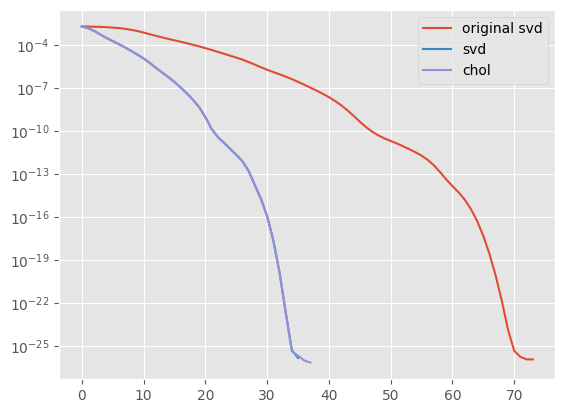

In [81]:
plt.plot(convergence_data['loss_vals'],label = 'original svd')
plt.plot(convergence.loss_vals,label = 'svd')
plt.plot(chol_convergence.loss_vals,label = 'chol')
plt.yscale('log')
plt.legend()

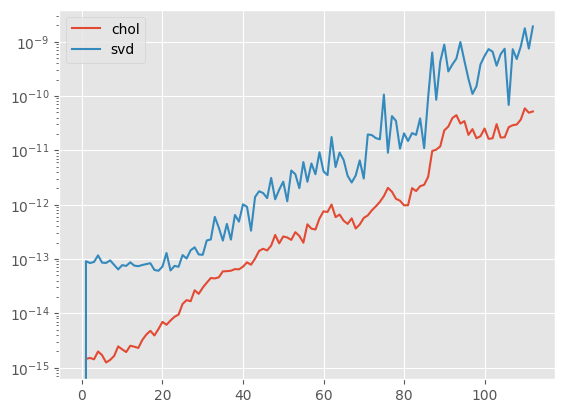

In [55]:
plt.plot(chol_convergence.linear_system_rel_residual,label = 'chol')
plt.plot(convergence.linear_system_rel_residual,label = 'svd')
plt.yscale('log')
plt.legend()

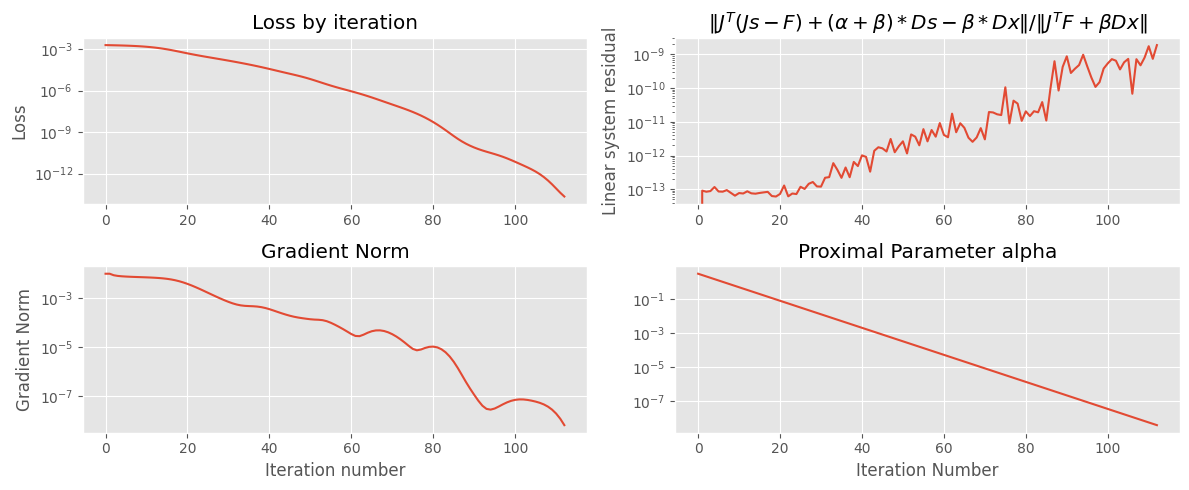

In [56]:
plot_optimization_results(convergence)